# Load data

https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [1]:
import re
import numpy as np
import pandas as pd
import sys; sys.path.insert(0, '..')
from data.utils import split_data
import gender_guesser.detector as detector

In [2]:
# Load data
df = pd.read_table('../data/AB_NYC_2019.csv', sep=',',
                   header=0, index_col=None)

# Type conversions
df['name'] = df['name'].astype(str)
df['host_name'] = df['host_name'].astype(str)
df['last_review'] = pd.to_datetime(df['last_review'])

# Sample rows
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [3]:
# Categorical features
categorical_columns = ['neighbourhood_group', 'neighbourhood', 'room_type']
for column in categorical_columns:
    df[column] = pd.Categorical(df[column]).codes

In [4]:
# Exclude outliers (top 0.5%)
df = df[df['price'] < df['price'].quantile(0.995)]

In [5]:
# Features derived from name
df['name_length'] = df['name'].apply(lambda x: len(x))
df['name_isupper'] = df['name'].apply(lambda x: int(x.isupper()))
df['name_words'] = df['name'].apply(lambda x: len(re.findall(r'\w+', x)))

In [6]:
# Host gender guess
guesser = detector.Detector()
df['host_gender'] = df['host_name'].apply(lambda x: guesser.get_gender(x.split(' ')[0]))
df['host_gender'] = pd.Categorical(df['host_gender']).codes

In [7]:
# Number of days since last review
most_recent = df['last_review'].max()
df['last_review'] = (most_recent - df['last_review']).dt.days
df['last_review'] = (df['last_review'] - df['last_review'].mean()) / df['last_review'].std()
df['last_review'] = df['last_review'].fillna(-5)

In [8]:
# Missing values
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [9]:
# Normalize other numerical features
df['number_of_reviews'] = (df['number_of_reviews'] - df['number_of_reviews'].mean()) / df['number_of_reviews'].std()
df['availability_365'] = (df['availability_365'] - df['availability_365'].mean()) / df['availability_365'].std()
df['name_length'] = (df['name_length'] - df['name_length'].mean()) / df['name_length'].std()

In [10]:
# Normalize latitude and longitude
df['latitude'] = (df['latitude'] - df['latitude'].mean()) / df['latitude'].std()
df['longitude'] = (df['longitude'] - df['longitude'].mean()) / df['longitude'].std()

In [11]:
# Drop columns
df = df.drop(['id', 'host_id', 'host_name', 'name'], axis=1)

In [12]:
# New sample rows
df.head(5)

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,name_length,name_isupper,name_words,host_gender
0,1,108,-1.492033,-0.440795,1,149,1,-0.321948,-0.034852,0.21,6,1.922931,-0.276169,0,7,2
1,2,127,0.452497,-0.687792,0,225,1,0.484307,-0.552366,0.38,2,1.846815,-1.513431,0,3,1
2,2,94,1.467544,0.219381,1,150,3,-0.523512,-5.000000,0.00,1,1.922931,-0.180995,1,6,1
3,1,41,-0.802204,-0.167581,0,89,1,5.523401,-0.661188,4.64,1,0.621350,-0.561691,0,5,5
4,2,61,1.274978,0.174098,0,80,10,-0.321948,-0.109819,0.10,1,-0.855298,1.056268,0,8,1


In [13]:
# Rearrange columns
target_col = 'price'
cols = df.columns.tolist()
del cols[cols.index(target_col)]
cols.append(target_col)
feature_names = cols[:-1]
df = df[cols]

# Split data
train, val, test = split_data(df.values, seed=123,
                              val_portion=0.1,
                              test_portion=0.1)
Y_train = train[:, -1:].copy()
Y_val = val[:, -1:].copy()
Y_test = test[:, -1:].copy()
train = train[:, :-1].copy()
val = val[:, :-1].copy()
test = test[:, :-1].copy()

# Train model

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, BatchSampler

In [15]:
# Create model
device = torch.device('cuda')
model = nn.Sequential(
    nn.Linear(len(feature_names), 512),
    nn.ELU(),
    nn.Linear(512, 512),
    nn.ELU(),
    nn.Linear(512, 1)).to(device)

# Training parameters
lr = 1e-3
mbsize = 512
max_nepochs = 250
loss_fn = nn.MSELoss()
lookback = 20
verbose = False

# Data loaders
train_set = TensorDataset(
    torch.tensor(train, dtype=torch.float32),
    torch.tensor(Y_train, dtype=torch.float32))
train_loader = DataLoader(train_set, batch_size=mbsize, shuffle=True)
val_x = torch.tensor(val, dtype=torch.float32, device=device)
val_y = torch.tensor(Y_val, dtype=torch.float32, device=device)
test_x = torch.tensor(test, dtype=torch.float32, device=device)
test_y = torch.tensor(Y_test, dtype=torch.float32, device=device)

# Setup
optimizer = optim.Adam(model.parameters(), lr=lr)
min_criterion = np.inf
min_epoch = 0

# Train
for epoch in range(max_nepochs):
    for x, y in train_loader:
        # Move to device
        x = x.to(device=device)
        y = y.to(device=device)

        # Take gradient step
        loss = loss_fn(model(x), y)
        loss.backward()
        optimizer.step()
        model.zero_grad()

    # Check progress.
    with torch.no_grad():
        # Calculate validation loss.
        val_loss = loss_fn(model(val_x), val_y).item()
        if verbose:
            print('{}Epoch = {}{}'.format('-' * 10, epoch + 1, '-' * 10))
            print('Val loss = {:.4f}'.format(val_loss))

        # Check convergence criterion.
        if val_loss < min_criterion:
            min_criterion = val_loss
            min_epoch = epoch
            best_model = deepcopy(model)
        elif (epoch - min_epoch) == lookback:
            if verbose:
                print('Stopping early')
            break

# Keep best model
model = best_model

In [16]:
# Calculate performance
mean = torch.mean(train_set.tensors[1], dim=0, keepdim=True).to(device)
base_mse = nn.MSELoss()(mean.repeat(len(test_y), 1), test_y)
mse = nn.MSELoss()(model(test_x), test_y)

print('Base rate MSE = {:.2f}'.format(base_mse))
print('Model MSE = {:.2f}'.format(mse))

Base rate MSE = 12805.41
Model MSE = 7059.29


# Calculate individual feature importance

In [17]:
import sage

In [18]:
# Setup and calculate
imputer = sage.MarginalImputer(test[:512])
sampler = sage.PermutationSampler(model, imputer, 'mse')
sage_values = sampler(test, Y_test)

Estimating convergence time
Batch size = batch * samples = 262144


StdDev Ratio = 0.1358 (Converge at 0.0500)
StdDev Ratio = 0.0987 (Converge at 0.0500)
StdDev Ratio = 0.0734 (Converge at 0.0500)
StdDev Ratio = 0.0650 (Converge at 0.0500)
StdDev Ratio = 0.0610 (Converge at 0.0500)
StdDev Ratio = 0.0568 (Converge at 0.0500)
StdDev Ratio = 0.0526 (Converge at 0.0500)
StdDev Ratio = 0.0500 (Converge at 0.0500)
StdDev Ratio = 0.0483 (Converge at 0.0500)
Detected convergence



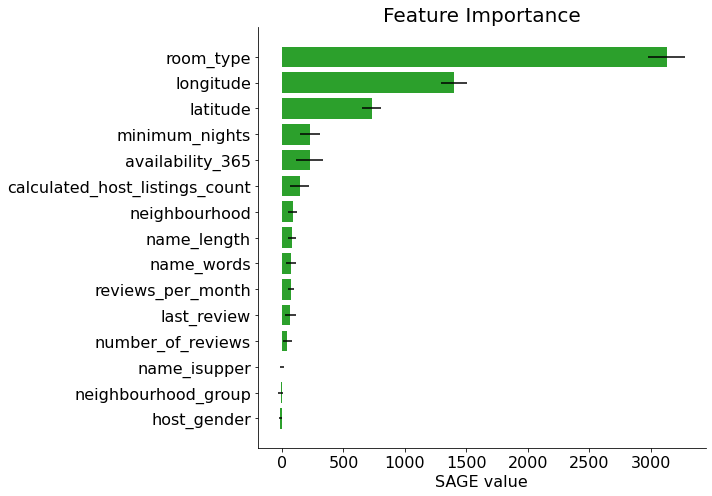

In [19]:
# Plot results
sage_values.plot(feature_names)

# Calculate grouped feature importance

In [20]:
# Feature groups
feature_groups = group_names = {
    'location (grouped)': ['latitude', 'longitude', 'neighbourhood', 'neighbourhood_group'],
    'name (grouped)': ['name_words', 'name_length', 'name_isupper'],
    'reviews (grouped)': ['last_review', 'reviews_per_month', 'number_of_reviews'],
    'host (grouped)': ['host_gender', 'calculated_host_listings_count']
}
group_names = [group for group in feature_groups]
for col in feature_names:
    if np.all([col not in group[1] for group in feature_groups.items()]):
        group_names.append(col)

# Group indices
groups = []
for _, group in feature_groups.items():
    ind_list = []
    for feature in group:
        ind_list.append(cols.index(feature))
    groups.append(ind_list)

In [21]:
# Setup and calculate
imputer = sage.GroupedMarginalImputer(test[:512], groups)
sampler = sage.PermutationSampler(model, imputer, 'mse')
sage_values = sampler(test, Y_test)

Estimating convergence time
Batch size = batch * samples = 262144


StdDev Ratio = 0.1639 (Converge at 0.0500)
StdDev Ratio = 0.1063 (Converge at 0.0500)
StdDev Ratio = 0.0870 (Converge at 0.0500)
StdDev Ratio = 0.0723 (Converge at 0.0500)
StdDev Ratio = 0.0645 (Converge at 0.0500)
StdDev Ratio = 0.0577 (Converge at 0.0500)
StdDev Ratio = 0.0546 (Converge at 0.0500)
StdDev Ratio = 0.0552 (Converge at 0.0500)
StdDev Ratio = 0.0520 (Converge at 0.0500)
StdDev Ratio = 0.0492 (Converge at 0.0500)
Detected convergence



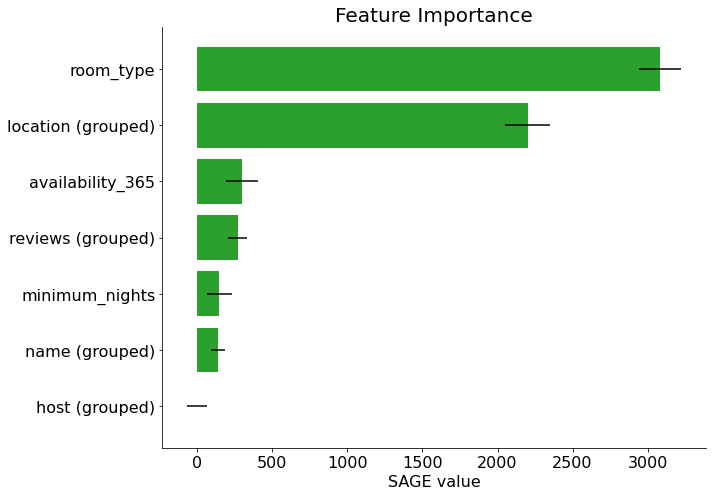

In [22]:
# Plot results
sage_values.plot(group_names)